In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import math

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import torchaudio
import torchaudio.transforms as T

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [38]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [48]:
def librosa_spec_plot(spec):
    fig, axs = plt.subplots(1, 1)
    axs.set_title('Spectrogram (db)')
    axs.set_ylabel('freq')
    axs.set_xlabel('frame')
    librosa.display.specshow(spec.numpy(), sr=sr)
    

In [4]:
healthy_audios = []
disorder_audios = []

healthy_audios.append('../voice_data/fusion/healthy/phrase/1-phrase.wav')
healthy_audios.append('../voice_data/fusion/healthy/phrase/2-phrase.wav')
healthy_audios.append('../voice_data/fusion/healthy/phrase/3-phrase.wav')

disorder_audios.append('../voice_data/fusion/pathology/phrase/108-phrase.wav')
disorder_audios.append('../voice_data/fusion/pathology/phrase/109-phrase.wav')
disorder_audios.append('../voice_data/fusion/pathology/phrase/110-phrase.wav')


healthy_audios =[ librosa.load(aud, sr=16000)[0] for aud in healthy_audios ]
disorder_audios =[ librosa.load(aud, sr=16000)[0] for aud in disorder_audios ]



Text(0.5, 1.0, 'Waveform')

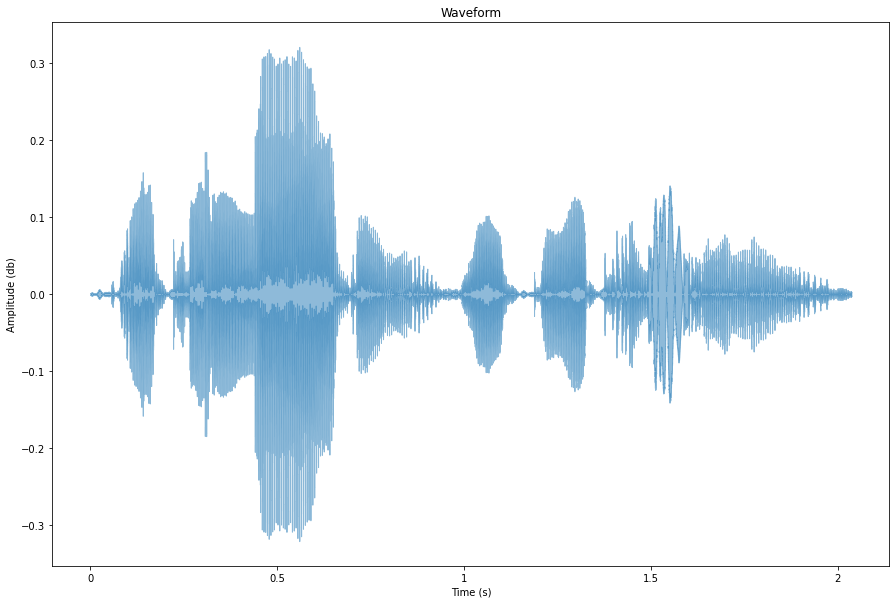

In [34]:
FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(healthy_audios[0], sr=sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (db)")
plt.title("Waveform")

Text(0.5, 1.0, 'Spectrogram (dB)')

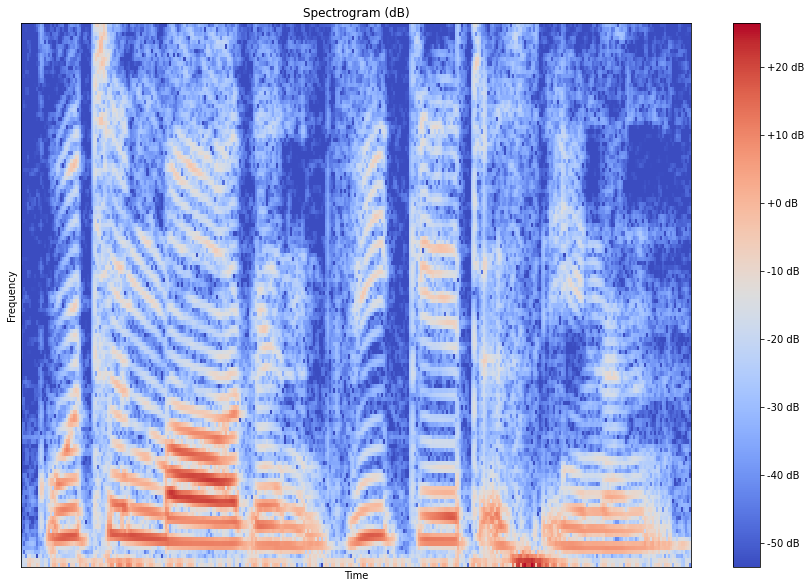

In [35]:
stfts=librosa.stft(healthy_audios[0],win_length=win_length,n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=FIG_SIZE)
magnitude = np.abs(stfts)
log_spectrogram = librosa.amplitude_to_db(magnitude)
librosa.display.specshow(log_spectrogram[:128,:], sr=sr)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [154]:
spec_healthy=torch.from_numpy(log_spectrogram[:128,:]).type(torch.float32)
spec_healthy.shape

torch.Size([128, 326])

In [155]:
spec_healthy1=torch.from_numpy(log_spectrogram[:128,:]).type(torch.float32)
spec_healthy1.shape

torch.Size([128, 326])

In [156]:
spec_healthy2=torch.from_numpy(log_spectrogram[:128,:]).type(torch.float32)
spec_healthy2.shape

torch.Size([128, 326])

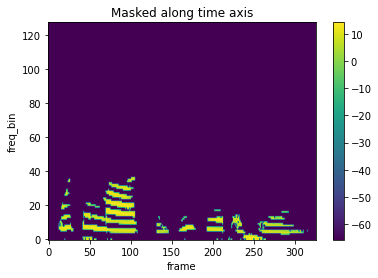

In [171]:
#torch.random.manual_seed(4)
masking = T.TimeMasking(time_mask_param=30,iid_masks=True)

spec = masking(spec_healthy)
spec1 = masking(spec_healthy1)
spec2 = masking(spec_healthy2)





plot_spectrogram(spec, title="Masked along time axis")

In [170]:
torch.stack([spec_healthy,spec_healthy1,spec_healthy2]).size()

torch.Size([3, 128, 326])

In [172]:
mask_stack=masking(torch.stack([spec_healthy,spec_healthy1,spec_healthy2]))

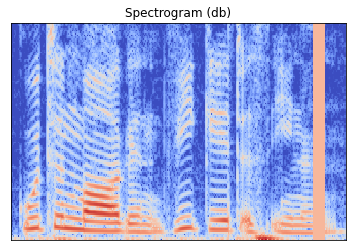

In [173]:
librosa_spec_plot(mask_stack[0])

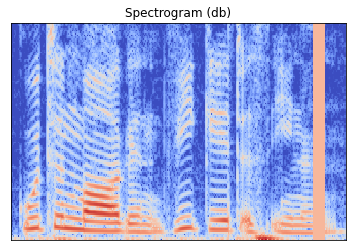

In [174]:
librosa_spec_plot(mask_stack[1])

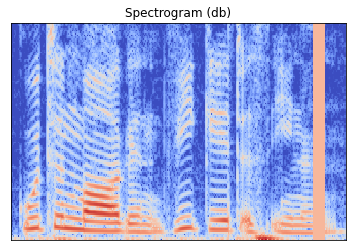

In [175]:
librosa_spec_plot(mask_stack[2])

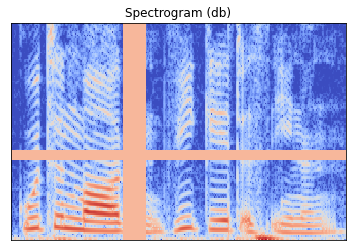

In [176]:

masking = T.FrequencyMasking(freq_mask_param=13,iid_masks =True) # Indices uniformly sampled from [0, freq_mask_param). 최대 30개
spec = masking(spec)

librosa_spec_plot(spec)

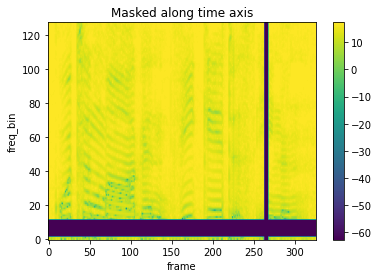

In [113]:
plot_spectrogram(torch.abs(spec), title="Masked along time axis")

# spec mix

Sxx.shape: torch.Size([8, 3, 128, 300])
mask_height: 12
mask_width: 30
masked_size: tensor(28416)
tensor([0, 1, 1, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 0, 0, 1, 0])


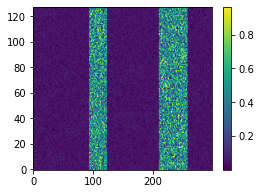

In [151]:

from typing import List, Tuple, Union
import numpy as np
import torch
from torch import Tensor


class SpecMix(object):
    def __init__(self, gamma: float = 0.3, n_max_mask_bars: int = 3):
        self.gamma = gamma
        self.n_max_mask_bars = n_max_mask_bars

    def _select_mask_start_points(self, Sxx: Tensor, f_: int, mask_len: int, kind: str) -> List[int]:
        if kind == 'freq':
            mask_step_ = np.random.randint(0, Sxx.shape[2] + 1 - mask_len, f_)
        elif kind == 'time':
            mask_step_ = np.random.randint(0, Sxx.shape[3] + 1 - mask_len, f_)
        else:
            raise ValueError
        mask_step_ = sorted(mask_step_)
        return mask_step_

    def _get_mask_range(self, mask_step_: List[int], mask_len: int) -> List[Tuple[int, int]]:
        mask_range_ = []
        for m_step in mask_step_:
            mask_range_.append((m_step, m_step + mask_len))
        return mask_range_

    def _clean_mask_range_(self, mask_range_: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        cleaned_mask_range_ = [mask_range_[0]]
        track_range = mask_range_[0]  # init
        prev_added = True
        for i in range(len(mask_range_) - 1):
            if mask_range_[i + 1][0] - track_range[1] > 0:  # if two ranges are not overlapped.
                track_range = mask_range_[i + 1]
                cleaned_mask_range_.append(mask_range_[i + 1])
                prev_added = True
            else:  # if two ranges are overlapped.
                track_range = (track_range[0], mask_range_[i + 1][1])
                if prev_added:
                    cleaned_mask_range_.pop(-1)
                    prev_added = False
                if i == len(mask_range_) - 2:
                    cleaned_mask_range_.append(track_range)
        return cleaned_mask_range_

    def __call__(self, Sxx: Tensor, labels: Tensor):
        """
        :param Sxx: (batch_size, channel_size, height, width)
        :param labels: (batch_size,)
        :return:
        """

        # select `f_freq` and `f_time` for the entire mini-batch, B_1.
        f_freq = np.random.randint(0, self.n_max_mask_bars + 1)
        f_time = np.random.randint(0, self.n_max_mask_bars + 1)

        # get a randomly-permuted (rp) mini-batch, `B_2`
        # 이 부분이 index를 렌덤으로 가져올 배치내 인덱스 선정하는 부분. 
        rand_index = torch.randperm(Sxx.size()[0])
        Sxx_rp = Sxx[rand_index, :, :, :]
        labels_rp = labels[rand_index]
        print('Sxx.shape:', Sxx.shape)

        # compute mask length for each masking
        mask_height = np.floor(Sxx.shape[2] * self.gamma).astype(int)
        mask_width = np.floor(Sxx.shape[3] * self.gamma).astype(int)
        print('mask_height:', mask_height)
        print('mask_width:', mask_width)

        # compute masking steps in y-axis (freq-axis) and x-axis (time-axis)
        mask_step_f = self._select_mask_start_points(Sxx, f_freq, mask_height, 'freq')
        mask_step_t = self._select_mask_start_points(Sxx, f_time, mask_width, 'time')
        # print('mask_step_f:', mask_step_f)
        # print('mask_step_t:', mask_step_t)

        # compute masking ranges in y-axis (freq-axis) and x-axis (time-axis)
        mask_range_f = self._get_mask_range(mask_step_f, mask_height)
        mask_range_t = self._get_mask_range(mask_step_t, mask_width)
        # print('mask_range_f:', mask_range_f)
        # print('mask_range_t:', mask_range_t)

        # mask in y-axis (freq-axis)
        Sxx_rp_ = torch.zeros(Sxx_rp.shape).float().to(Sxx.device)
        if mask_range_f:
            cleaned_mask_range_f = self._clean_mask_range_(mask_range_f)
            # print('cleaned_mask_range_f:', cleaned_mask_range_f)
            # mask - freq
            for rng in cleaned_mask_range_f:
                Sxx[:, :, rng[0]:rng[1], :] = 0.
                Sxx_rp_[:, :, rng[0]:rng[1], :] = Sxx_rp[:, :, rng[0]:rng[1], :]

        # mask in x-axis (time-axis)
        if mask_range_t:
            cleaned_mask_range_t = self._clean_mask_range_(mask_range_t)
            # print('cleaned_mask_range_t:', cleaned_mask_range_t)
            # mask - time
            for rng in cleaned_mask_range_t:
                Sxx[:, :, :, rng[0]:rng[1]] = 0.
                Sxx_rp_[:, :, :, rng[0]:rng[1]] = Sxx_rp[:, :, :, rng[0]:rng[1]]

        # mix as Eq. (1) in the original paper
        mixed_Sxx = (Sxx + Sxx_rp_).float()

        # compute `lambda` as in Eq. (2)
        masked_size = (Sxx[0][0] != 0).int().sum()
        img_size = Sxx[0][0].shape[0] * Sxx[0][0].shape[1]
        lambda_ = masked_size / img_size
        print('masked_size:', masked_size)
        # print('img_size:', img_size)
        # print('lambda_:', lambda_)
        # print('\n\n')
        return mixed_Sxx, lambda_, labels, labels_rp


if __name__ == '__main__':
    # 이진 분류에 사용할 수 있는 코드 방법.
    
    import random
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    #random.seed(2)
    #np.random.seed(1)
    #torch.manual_seed(0)

    # toy dataset
    batch_size = 8
    channel_size = 3
    height = 128
    width = 300
    Sxx = torch.rand((batch_size, channel_size, height, width)).abs()  # spectrogram (Sxx)
    scale = torch.rand((batch_size, 1, 1, 1))
    Sxx = Sxx * scale
    labels = torch.randint(0, 2, (batch_size, ))

    # apply SpecMix
    spec_mix = SpecMix(gamma=0.1, n_max_mask_bars=3)  # default gamma value is 0.3 in the paper.
    mixed_Sxx, lambda_, labels, labels_rp = spec_mix(Sxx, labels)
    print(labels)
    print(labels_rp)
    
    # loss would look like:
    # loss = lambda_ * criterion(pred_labels, labels) + (1 - lambda_) * criterion(pred_labels, labels)

    # take sample
    mixed_sxx = mixed_Sxx[7][0]

    # plot
    fig, ax1 = plt.subplots(figsize=(4, 3))
    im1 = ax1.imshow(mixed_sxx, aspect='auto')
    ax1.invert_yaxis()
    fig.colorbar(im1)
    plt.show()

In [120]:
lambda_

tensor(0.8156)

In [70]:
torch.randint(0, 2, (batch_size, ))

tensor([0, 1, 1, 0, 1, 0, 0, 0])

In [16]:
mixed_Sxx[1][0].size()

torch.Size([224, 224])

In [7]:
torch.rand((batch_size, 1, 1, 1))

tensor([[[[0.4087]]],


        [[[0.2210]]],


        [[[0.7825]]],


        [[[0.0990]]],


        [[[0.1211]]],


        [[[0.5191]]],


        [[[0.7662]]],


        [[[0.5219]]]])

In [9]:
mixed_Sxx.size()

torch.Size([8, 1, 224, 224])